# Vaccination Strategies Analysis on Temporal Contact Networks

**Author:** Marcus Vinícius Santos Rodrigues  

**Description:** Simulation and comparison of vaccination strategies using real-world RFID contact networks (office, primary school, high school, hospital).

---

## 1. Introduction

This notebook implements an epidemic spreading study on real temporal contact networks, comparing different vaccination strategies (degree, k-core, betweenness, eigenvector, random) using the SIR model. Four public datasets collected via RFID sensors are analyzed.


## 2. Libraries and Configuration

Import all necessary Python libraries and set visualization preferences.

In [181]:
import pandas as pd
import numpy as np
from scipy.stats import t, f_oneway, kruskal, ttest_ind, mannwhitneyu
from itertools import combinations
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tqdm import tqdm
import warnings
import os

warnings.filterwarnings('ignore')

sns.set_theme(style="whitegrid", palette="muted")

## 3. Data Loading and Initial Exploration

Read the four datasets and display summary statistics about the data (number of contacts, time span, nodes, etc).

In [161]:
def load_primary_school(path_data, path_meta):
    df = pd.read_csv(path_data, sep='\t', engine='python')
    meta = pd.read_csv(path_meta, sep='\t', engine='python')
    return df, meta

def load_high_school(path_data, path_meta):
    df = pd.read_csv(path_data, sep='\t', engine='python')
    meta = pd.read_csv(path_meta, sep='\t', engine='python')
    return df, meta

def load_office(path_data, path_meta):
    df = pd.read_csv(path_data, sep='\t', engine='python')
    meta = pd.read_csv(path_meta, sep='\t', engine='python')
    return df, meta

def load_hospital(path_data):
    df = pd.read_csv(path_data, sep='\t', engine='python')
    return df

In [162]:
# Office
df_office, meta_office = load_office('datasets/office/office.csv',
                                     'datasets/office/metadata_office.csv')

# Hospital
df_hospital = load_hospital('datasets/hospital/hospital.csv')

# Primary School
df_primary, meta_primary = load_primary_school('datasets/primary_school/primary_school.csv',
                                              'datasets/primary_school/metadata_primary_school.csv')

# High School
df_high, meta_high = load_high_school('datasets/high_school/high_school.csv',
                                      'datasets/high_school/metadata_high_school.csv')

## 4. Network Construction and Preprocessing

Build the aggregated contact networks for each dataset and display some structural properties (number of nodes, edges, connected components, largest component visualization).

In [163]:
def aggregate_contacts(df, remove_selfloops=True):
    # Cria um grafo onde cada aresta tem peso igual ao número de contatos
    edges = df.groupby(['id1', 'id2']).size().reset_index(name='weight')
    if remove_selfloops:
        edges = edges[edges['id1'] != edges['id2']]
    G = nx.Graph()
    for _, row in edges.iterrows():
        G.add_edge(int(row['id1']), int(row['id2']), weight=int(row['weight']))
    return G

# Exemplos:
G_primary = aggregate_contacts(df_primary)
G_high = aggregate_contacts(df_high)
G_office = aggregate_contacts(df_office)
G_hospital = aggregate_contacts(df_hospital)

## 5. Centrality Measures Calculation

Calculate centralities used for the vaccination strategies: degree, k-core, betweenness, eigenvector.


Graph Primary School
Number of nodes: 242
Number of edges: 8317
Is connected? True
Number of connected components: 1
Size of the largest connected component: 242


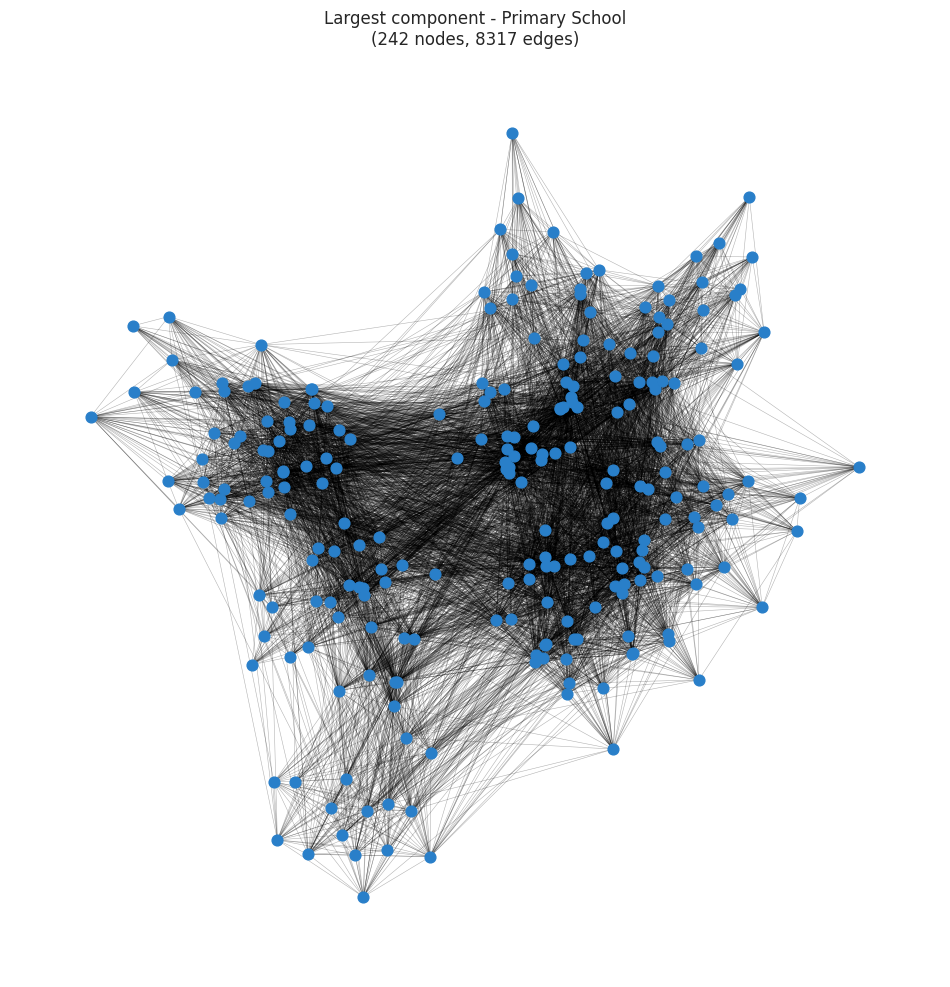


Graph High School
Number of nodes: 327
Number of edges: 5818
Is connected? True
Number of connected components: 1
Size of the largest connected component: 327


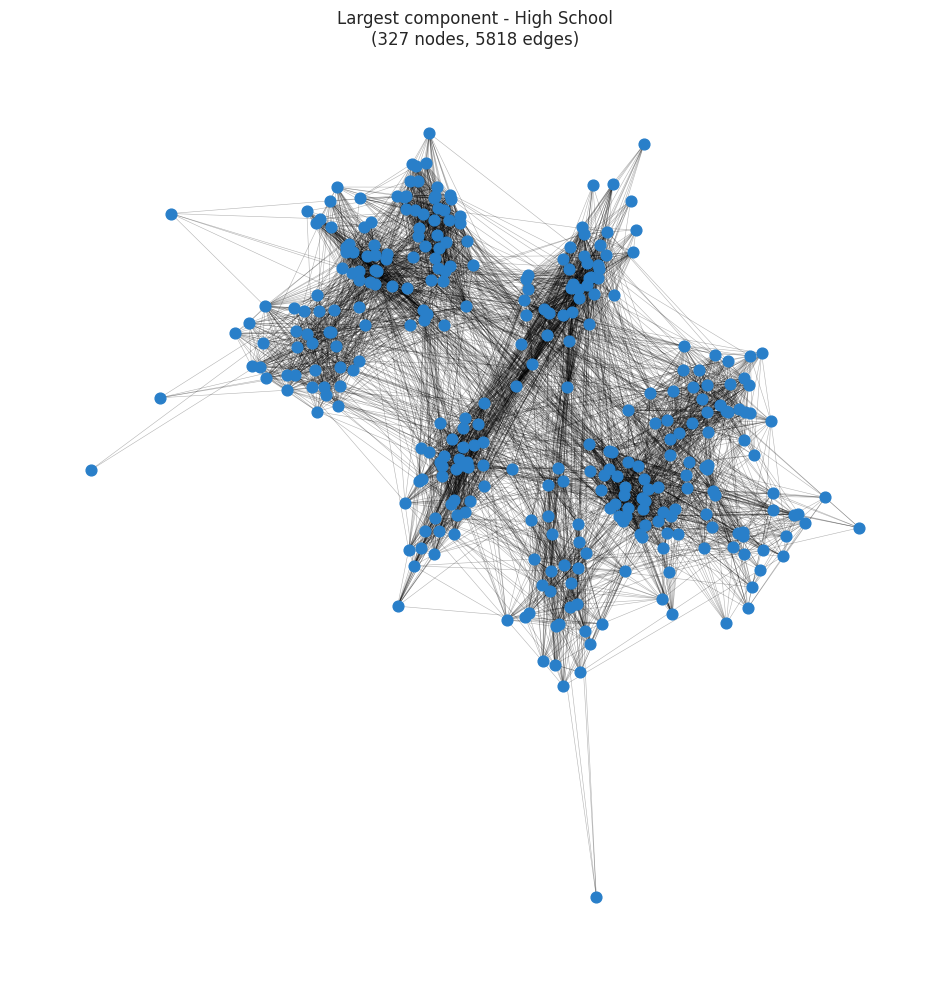


Graph Office
Number of nodes: 92
Number of edges: 755
Is connected? True
Number of connected components: 1
Size of the largest connected component: 92


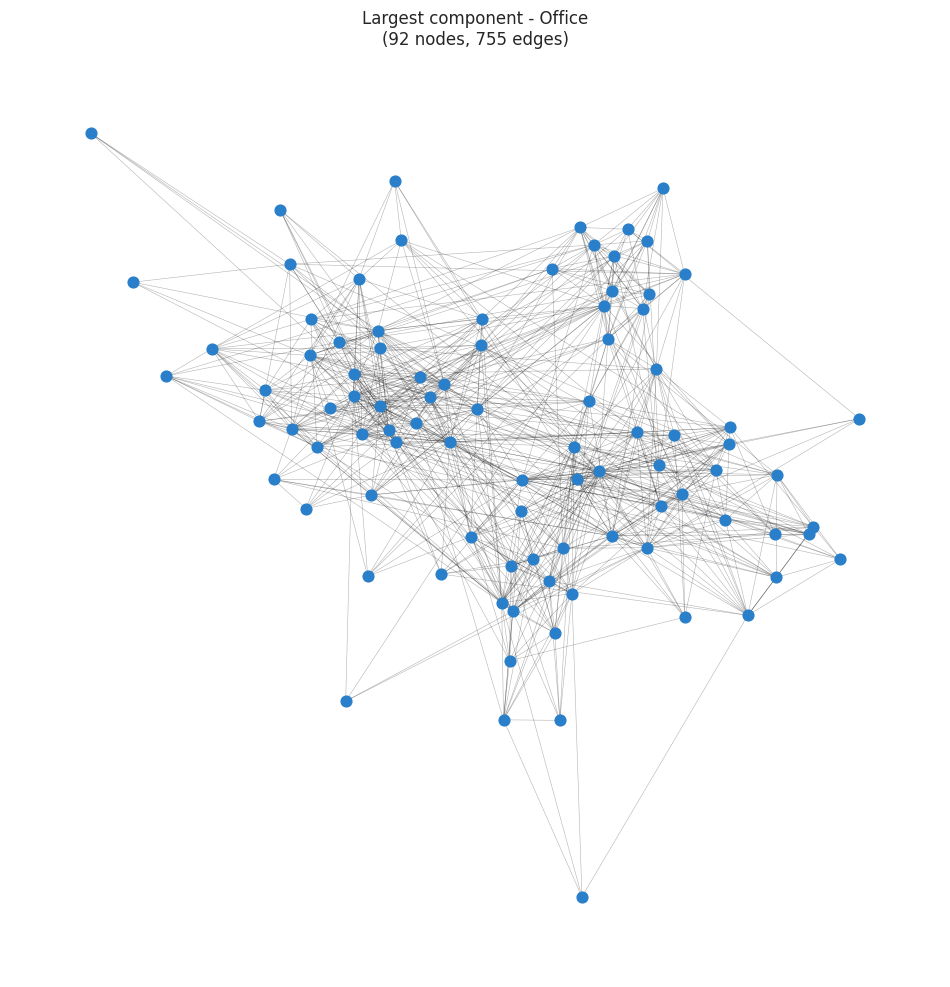


Graph Hospital
Number of nodes: 75
Number of edges: 1139
Is connected? True
Number of connected components: 1
Size of the largest connected component: 75


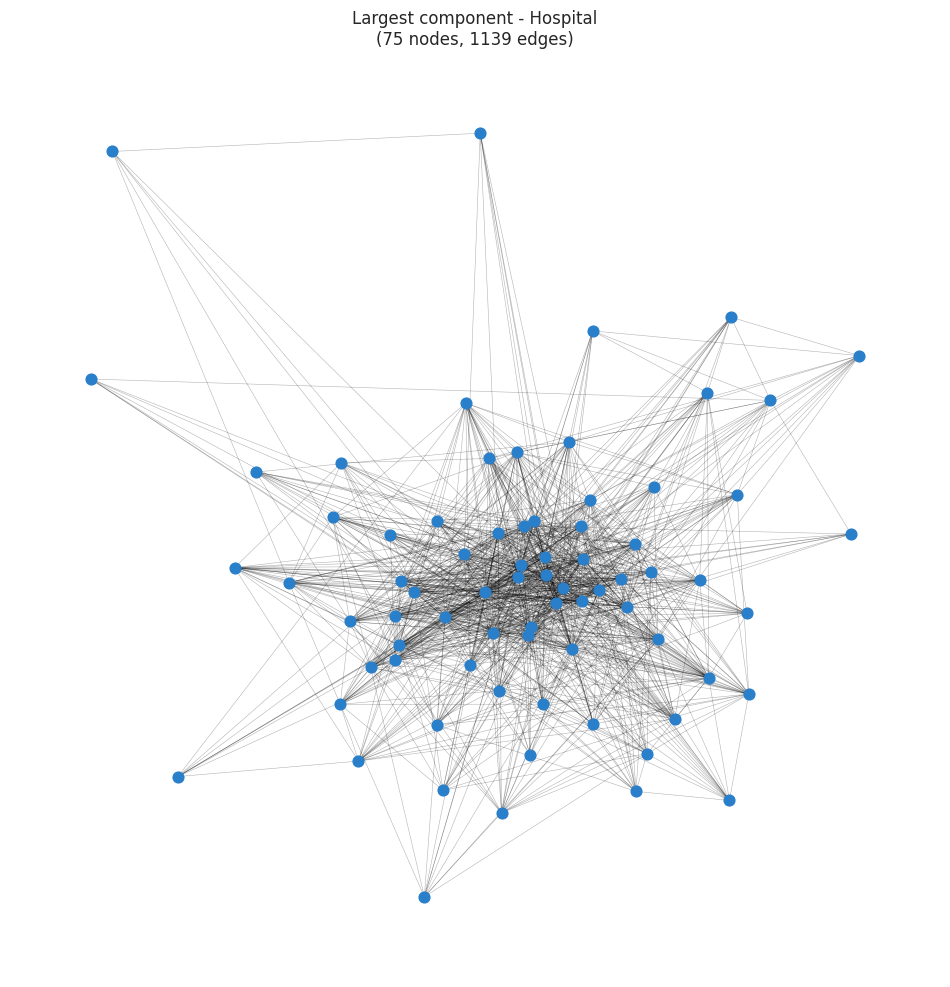

In [182]:
# Dataset names and preloaded graphs
datasets = {
    "Primary School": G_primary,
    "High School": G_high,
    "Office": G_office,
    "Hospital": G_hospital
}

for name, G in datasets.items():
    print(f"\nGraph {name}")
    print("Number of nodes:", G.number_of_nodes())
    print("Number of edges:", G.number_of_edges())
    if G.number_of_nodes() > 0 and G.number_of_edges() > 0:
        connected = nx.is_connected(G)
        print("Is connected?", connected)
        n_comp = nx.number_connected_components(G)
        print("Number of connected components:", n_comp)
        components = sorted(nx.connected_components(G), key=len, reverse=True)
        biggest_size = len(components[0]) if components else 0
        print("Size of the largest connected component:", biggest_size)
        
        # Visualization: largest component
        plt.figure(figsize=(12, 12))
        subG = G.subgraph(components[0])
        pos = nx.spring_layout(subG, seed=42)
        # Draw edges with low alpha
        nx.draw_networkx_edges(subG, pos, edge_color='#000', alpha=0.3, width=0.4)

        # Draw nodes with full opacity
        nx.draw_networkx_nodes(subG, pos, node_size=60, node_color='#297fc9', alpha=1.0)
        plt.title(f"Largest component - {name}\n({biggest_size} nodes, {subG.number_of_edges()} edges)")
        plt.axis('off')
        plt.show()
    else:
        print("The graph is empty!")
        # Symbolic visualization for an empty graph
        plt.figure(figsize=(3, 3))
        plt.text(0.5, 0.5, "Empty", fontsize=18, ha='center')
        plt.title(name)
        plt.axis('off')
        plt.show()

In [165]:
def compute_centralities(G):
    centralities = {
        'degree': nx.degree_centrality(G),
        'kcore': nx.core_number(G),
        'betweenness': nx.betweenness_centrality(G, k=min(200, len(G)), seed=42),
        'eigencentrality': nx.eigenvector_centrality_numpy(G)
    }
    return centralities

centralities_primary = compute_centralities(G_primary)
centralities_high = compute_centralities(G_high)
centralities_office = compute_centralities(G_office)
centralities_hospital = compute_centralities(G_hospital)

In [183]:
temporal_datasets = {
    "Primary School": df_primary,
    "High School": df_high,
    "Office": df_office,
    "Hospital": df_hospital
}

for name, df in temporal_datasets.items():
    timestamps = df['timestamp']
    min_time = timestamps.min()
    max_time = timestamps.max()
    n_events = len(timestamps)
    n_times = len(np.unique(timestamps))
    print(f"{name}:")
    print(f"  - First timestamp: {min_time}")
    print(f"  - Last timestamp:   {max_time}")
    print(f"  - Interval (max - min): {max_time - min_time}")
    print(f"  - Number of events (rows): {n_events}")
    print(f"  - Number of unique timestamps: {n_times}")
    print()

Primary School:
  - First timestamp: 31220
  - Last timestamp:   148120
  - Interval (max - min): 116900
  - Number of events (rows): 125773
  - Number of unique timestamps: 3100

High School:
  - First timestamp: 1385982020
  - Last timestamp:   1386345580
  - Interval (max - min): 363560
  - Number of events (rows): 188508
  - Number of unique timestamps: 7375

Office:
  - First timestamp: 28820
  - Last timestamp:   1016440
  - Interval (max - min): 987620
  - Number of events (rows): 9827
  - Number of unique timestamps: 7104

Hospital:
  - First timestamp: 140
  - Last timestamp:   347640
  - Interval (max - min): 347500
  - Number of events (rows): 32424
  - Number of unique timestamps: 9453



## 6. Vaccination Strategies

Define the algorithms for node selection according to each strategy.

In [ ]:
def select_vaccinated(G, centrality_dict, fraction, strategy='degree'):
    """
    Choose a fraction of nodes to vaccinate, according to a given strategy.
    
    Args:
        G: networkx.Graph (aggregated or largest component)
        centrality_dict: dictionary of node centrality scores (by strategy)
        fraction: float [0,1] = fraction of nodes to vaccinate
        strategy: one of 'random', 'degree', 'kcore', 'betweenness', 'eigencentrality'
    
    Returns:
        vaccinated: set of node IDs
    """
    n_vaccinated = int(fraction * len(G))
    n_vaccinated = max(1, n_vaccinated)
    if strategy == 'random':
        return set(random.sample(list(G.nodes()), n_vaccinated))
    else:
        ranking = sorted(centrality_dict[strategy].items(), key=lambda x: x[1], reverse=True)
        return set([node for node, _ in ranking[:n_vaccinated]])

## 7. SIR Model Simulation (Time-Windowed)

Implement the SIR propagation model with support for dynamic (time-windowed) contact networks.

In [168]:
def run_SIR_timewindow(
    tick_dict, 
    node_set,
    tau=0.1, 
    gamma=0.1, 
    n_ticks=None, 
    vaccinated_nodes=set(), 
    initial_infected=None, 
    rng=None
):
    """
    Simulate SIR dynamics over time windows, updating the network at each tick.
    
    Args:
        tick_dict: dict {tick_index: [(u, v), ...]}, one per time window
        node_set: set of all individual IDs (nodes in the network)
        tau: infection probability per contact per tick
        gamma: recovery probability per infected per tick
        n_ticks: number of ticks to simulate (default: full data range)
        vaccinated_nodes: set of nodes who start immune (in 'Recovered')
        initial_infected: set or list of initial infected (if None, randomly pick one)
        rng: numpy random generator (optional, for reproducibility)
    
    Returns:
        history: list of dicts, with S/I/R counts for each tick
    """
    if rng is None:
        rng = np.random.default_rng()
    
    all_nodes = set(node_set)
    susceptible = set(all_nodes) - set(vaccinated_nodes)
    if initial_infected is None:
        initial_infected = {rng.choice(list(susceptible))}
    infected = set(initial_infected)
    susceptible -= infected
    recovered = set(vaccinated_nodes)

    history = []
    ticks = sorted(tick_dict.keys())
    if n_ticks is None:
        n_ticks = ticks[-1] + 1 if ticks else 0

    for tick in range(n_ticks):
        contacts = tick_dict.get(tick, [])
        # Build the contact graph for this tick
        G_tick = nx.Graph()
        G_tick.add_edges_from(contacts)
        new_infected = set()
        
        # Only active edges at this time can propagate infection
        for u, v in contacts:
            if (u in infected and v in susceptible):
                if rng.random() < tau:
                    new_infected.add(v)
            elif (v in infected and u in susceptible):
                if rng.random() < tau:
                    new_infected.add(u)
        
        # Update infection state
        susceptible -= new_infected
        infected |= new_infected

        # Each infected may recover independently (gamma per tick)
        new_recovered = set()
        for node in list(infected):
            if rng.random() < gamma:
                infected.remove(node)
                recovered.add(node)
                new_recovered.add(node)
        
        # Record S/I/R counts for this tick
        history.append({'S': len(susceptible), 'I': len(infected), 'R': len(recovered)})

        # Stop early if epidemic dies out
        if not infected:
            # Pad rest of ticks with same counts
            for _ in range(tick + 1, n_ticks):
                history.append({'S': len(susceptible), 'I': 0, 'R': len(recovered)})
            break

    return history

def repeat_SIR_timewindow(
    df_contacts,
    node_set,
    tau=0.1,
    gamma=0.1,
    vaccinated_nodes=set(),
    tick_size=60,
    n_runs=30,
    initial_infected=None,
    seed=42
):
    """
    Repeat the SIR time-window simulation multiple times to get statistics.
    
    Args:
        df_contacts: DataFrame of temporal contacts
        node_set: set of all node IDs
        tau: infection probability
        gamma: recovery probability
        vaccinated_nodes: set of initially immune nodes
        tick_size: size of each time window
        n_runs: how many independent simulation runs
        initial_infected: optionally, set/list of nodes to always use as seeds
        seed: base random seed
    
    Returns:
        mean: mean S/I/R counts at each tick (shape: [n_ticks, 3])
        std:  stddev S/I/R counts at each tick (shape: [n_ticks, 3])
        arr:  all runs, shape [n_runs, n_ticks, 3]
    """
    tick_dict, min_time = split_contacts_by_tick(df_contacts, tick_size)
    n_ticks = max(tick_dict.keys()) + 1 if tick_dict else 0

    all_histories = []
    rng = np.random.default_rng(seed)
    for i in range(n_runs):
        # Use a different seed per run for independence
        this_seed = rng.integers(0, 1e9)
        history = run_SIR_timewindow(
            tick_dict,
            node_set,
            tau=tau,
            gamma=gamma,
            n_ticks=n_ticks,
            vaccinated_nodes=vaccinated_nodes,
            initial_infected=initial_infected,
            rng=np.random.default_rng(this_seed)
        )
        all_histories.append(history)

    # Align all histories to the same length (pad with last value)
    maxlen = max(len(h) for h in all_histories)
    for h in all_histories:
        while len(h) < maxlen:
            h.append(h[-1])
    arr = np.array([ [ [x['S'], x['I'], x['R']] for x in h ] for h in all_histories ])
    mean = arr.mean(axis=0)
    std = arr.std(axis=0)
    return mean, std, arr

def split_contacts_by_tick(df_contacts, tick_size=60):
    """
    Split a DataFrame of temporal contacts into a dictionary of time windows (ticks).

    Only uses ['timestamp', 'id1', 'id2'], even if extra columns are present.

    Args:
        df_contacts: DataFrame with at least columns ['timestamp', 'id1', 'id2']
        tick_size: window size in seconds (e.g., 60 for 1-min ticks)
    
    Returns:
        tick_dict: dict mapping tick_index -> list of (id1, id2) contacts
        min_time: first timestamp in the data
    """
    # Make sure to use only timestamp, id1, id2
    df = df_contacts[['timestamp', 'id1', 'id2']].copy()
    min_time = df['timestamp'].min()
    df['tick'] = ((df['timestamp'] - min_time) // tick_size).astype(int)
    tick_dict = df.groupby('tick')[['id1', 'id2']].apply(lambda x: list(map(tuple, x.values))).to_dict()
    return tick_dict, min_time

## 8. Simulation Execution and Summary Statistics

Run the SIR simulations for each scenario and collect summary statistics (mean, std, median, quartiles, IQR, confidence intervals, etc).

In [169]:
# Organize the graphs and centralities in a dict
datasets = {
    "Primary School": (G_primary, centralities_primary),
    "High School": (G_high, centralities_high),
    "Office": (G_office, centralities_office),
    "Hospital": (G_hospital, centralities_hospital)
}

# Define simulation parameters
taus = [0.1, 0.3, 0.5]                # infection probabilities
gamma = 0.1                           # recovery probability per tick
fractions = np.arange(0.01, 0.21, 0.01) # vaccination coverage (0.01 to 0.2)
strategies = ['random', 'degree', 'kcore', 'betweenness', 'eigencentrality']
n_runs = 100                          # number of stochastic simulations
tick_size = 60                        # window size in seconds

# Wrap datasets, graphs, centralities for easy loop
datasets = {
    "Primary School": (df_primary, G_primary, centralities_primary),
    "High School": (df_high, G_high, centralities_high),
    "Office": (df_office, G_office, centralities_office),
    "Hospital": (df_hospital, G_hospital, centralities_hospital)
}

all_results = []
all_raw_results = []  # Store all individual simulation results

for ds_name, (df, G, centralities) in datasets.items():
    nodes = set(df['id1']) | set(df['id2'])  # All nodes present in the contact list
    total_sim = len(taus) * len(fractions) * len(strategies)
    with tqdm(total=total_sim, desc=f"Simulating {ds_name}") as pbar:
        for tau in taus:
            for frac in fractions:
                frac_rounded = np.round(frac, 2)  # Round fraction
                for strategy in strategies:
                    # Select vaccinated nodes according to strategy
                    vaccinated = select_vaccinated(G, centralities, frac_rounded, strategy)
                    # Run batch simulation (time-windowed SIR)
                    mean, std, arr = repeat_SIR_timewindow(
                        df_contacts=df,
                        node_set=nodes,
                        tau=tau,
                        gamma=gamma,
                        vaccinated_nodes=vaccinated,
                        tick_size=tick_size,
                        n_runs=n_runs,
                        initial_infected=None,
                        seed=42
                    )
                    # Get fraction recovered at the end for each simulation
                    R_final = arr[:, -1, 2] / len(nodes)  # shape (n_runs,)
                    
                    # Summary statistics
                    mean_R = np.mean(R_final)
                    std_R = np.std(R_final, ddof=1)
                    median_R = np.median(R_final)
                    q1 = np.percentile(R_final, 25)
                    q3 = np.percentile(R_final, 75)
                    iqr = q3 - q1
                    # 95% confidence interval for the mean using t-student
                    ci95 = t.interval(0.95, len(R_final)-1, loc=mean_R, scale=std_R/np.sqrt(len(R_final)))
                    
                    # Store summary statistics in the DataFrame
                    all_results.append({
                        'dataset': ds_name,
                        'tau': tau,
                        'fraction': frac_rounded,
                        'strategy': strategy,
                        'mean_R': mean_R,
                        'std_R': std_R,
                        'median_R': median_R,
                        'q1_R': q1,
                        'q3_R': q3,
                        'iqr_R': iqr,
                        'ci95_lower': ci95[0],
                        'ci95_upper': ci95[1],
                        'n': n_runs
                    })
                    
                    # Store all raw results for later statistical testing
                    for i, R in enumerate(R_final):
                        all_raw_results.append({
                            'dataset': ds_name,
                            'tau': tau,
                            'fraction': frac_rounded,
                            'strategy': strategy,
                            'run': i,
                            'R_final': R
                        })
                    pbar.update(1)

# DataFrames with summary and raw results
df_results_all = pd.DataFrame(all_results)
df_raw_results = pd.DataFrame(all_raw_results)

Simulating Hospital: 100%|██████████| 300/300 [03:35<00:00,  1.39it/s]


## 9. Results Visualization

Visualize the results using line plots with error bars (mean ± 95% CI), and boxplots for selected scenarios.

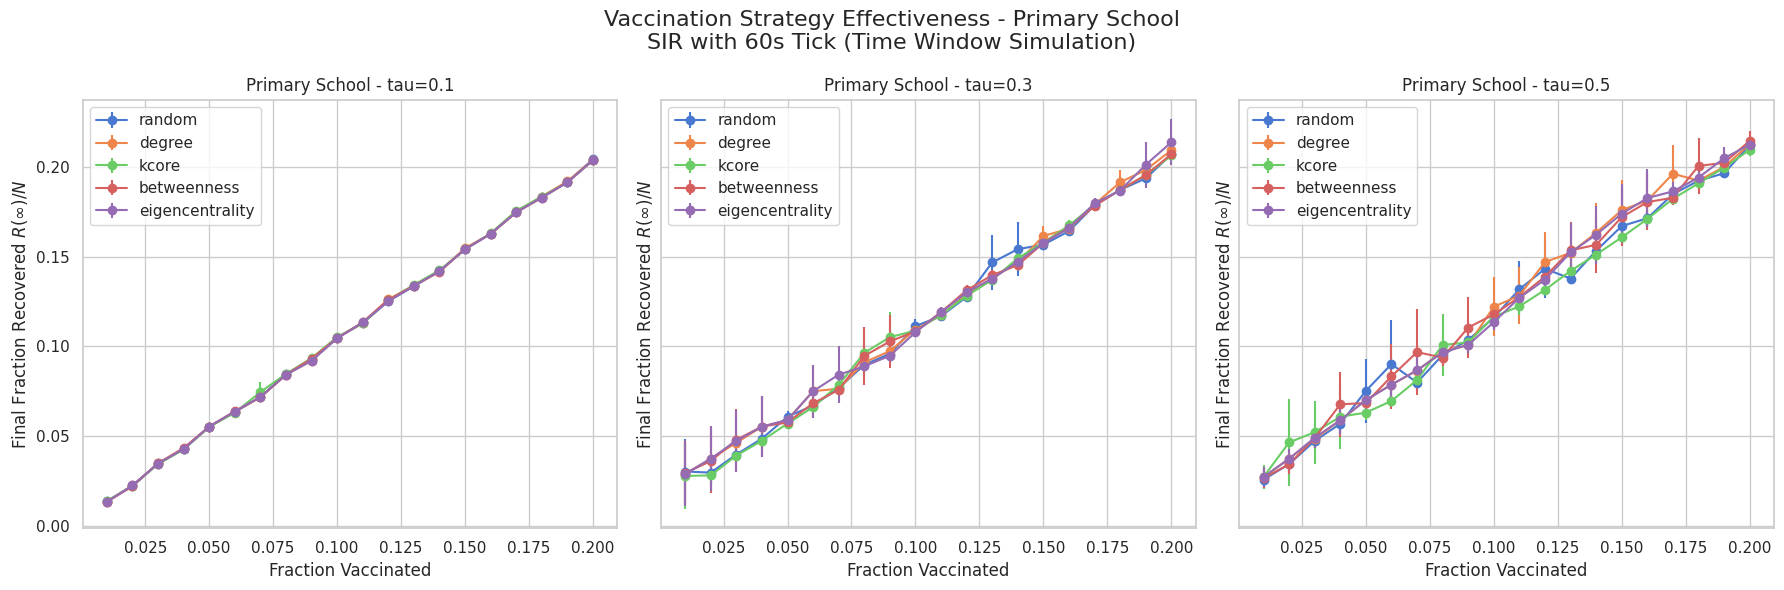

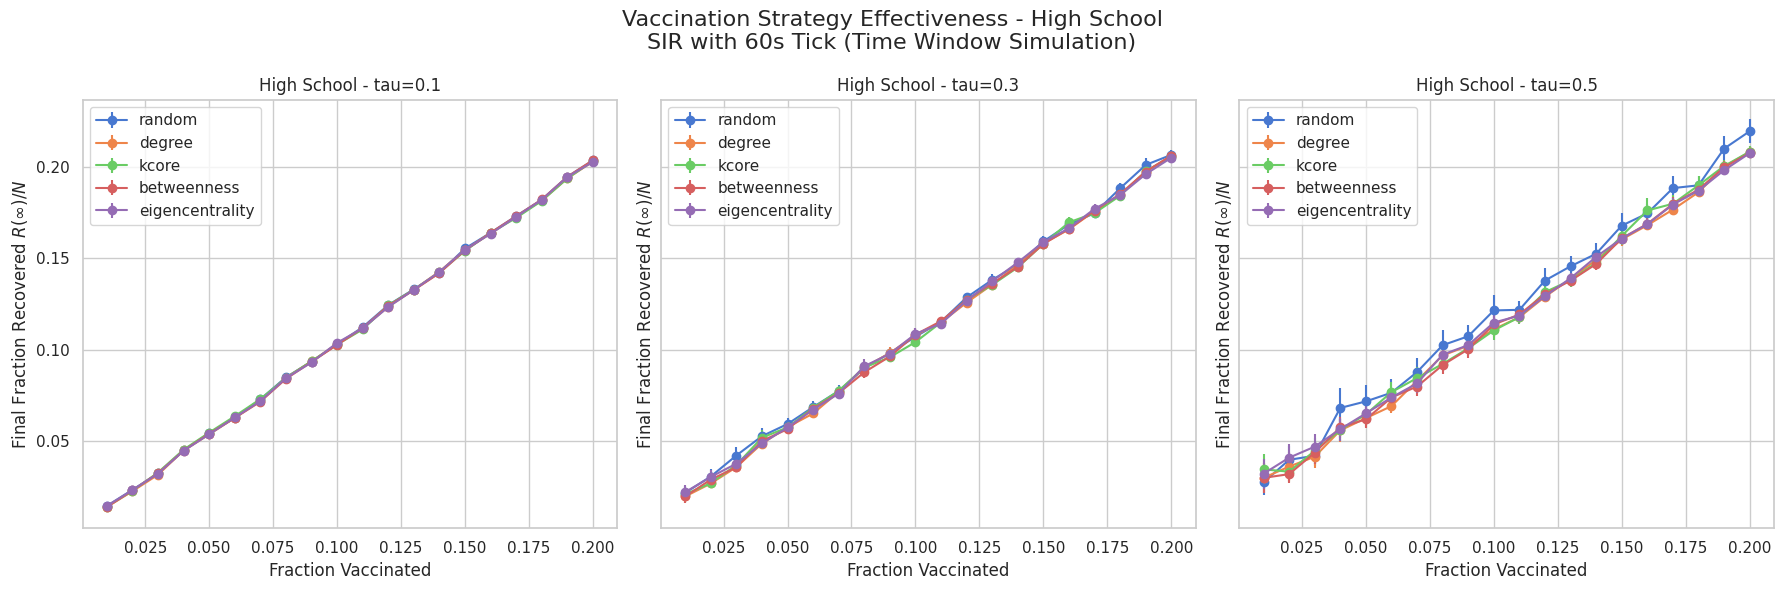

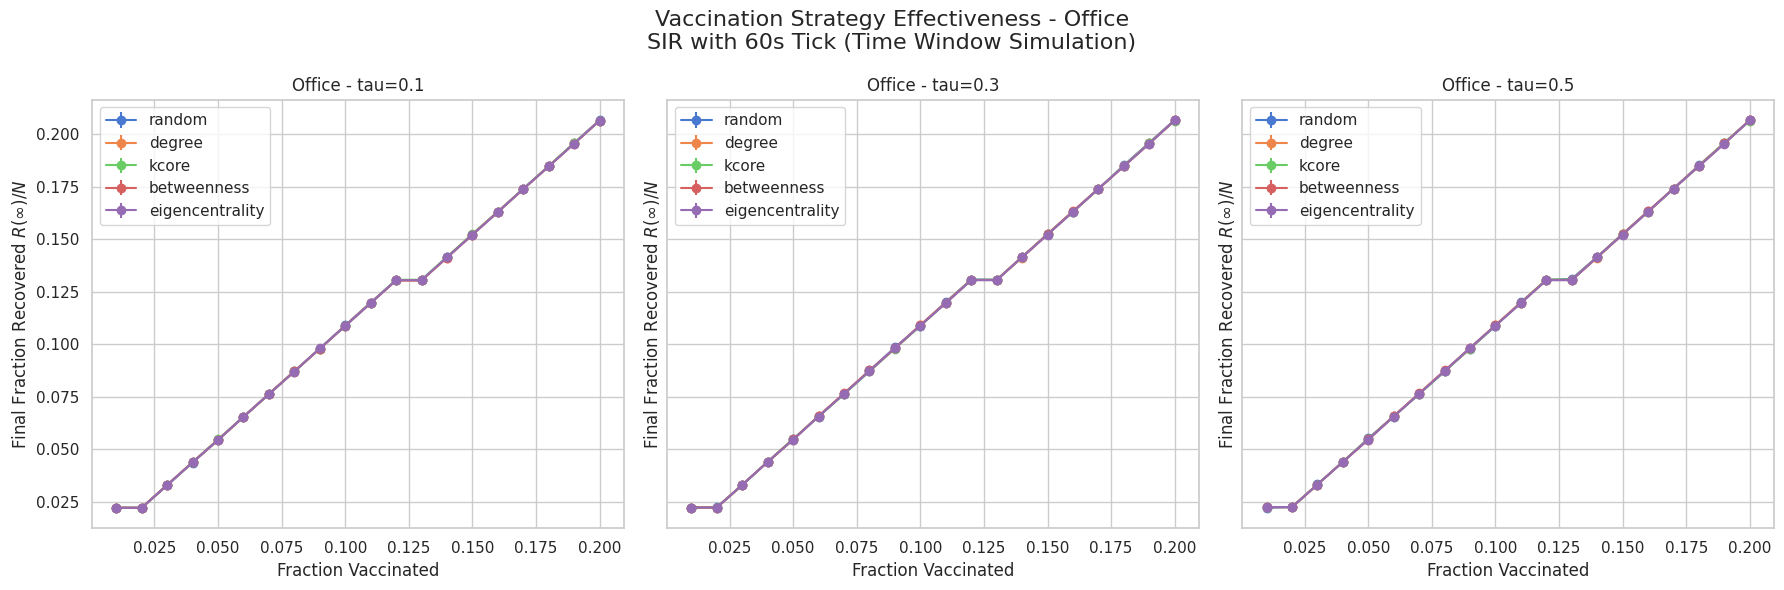

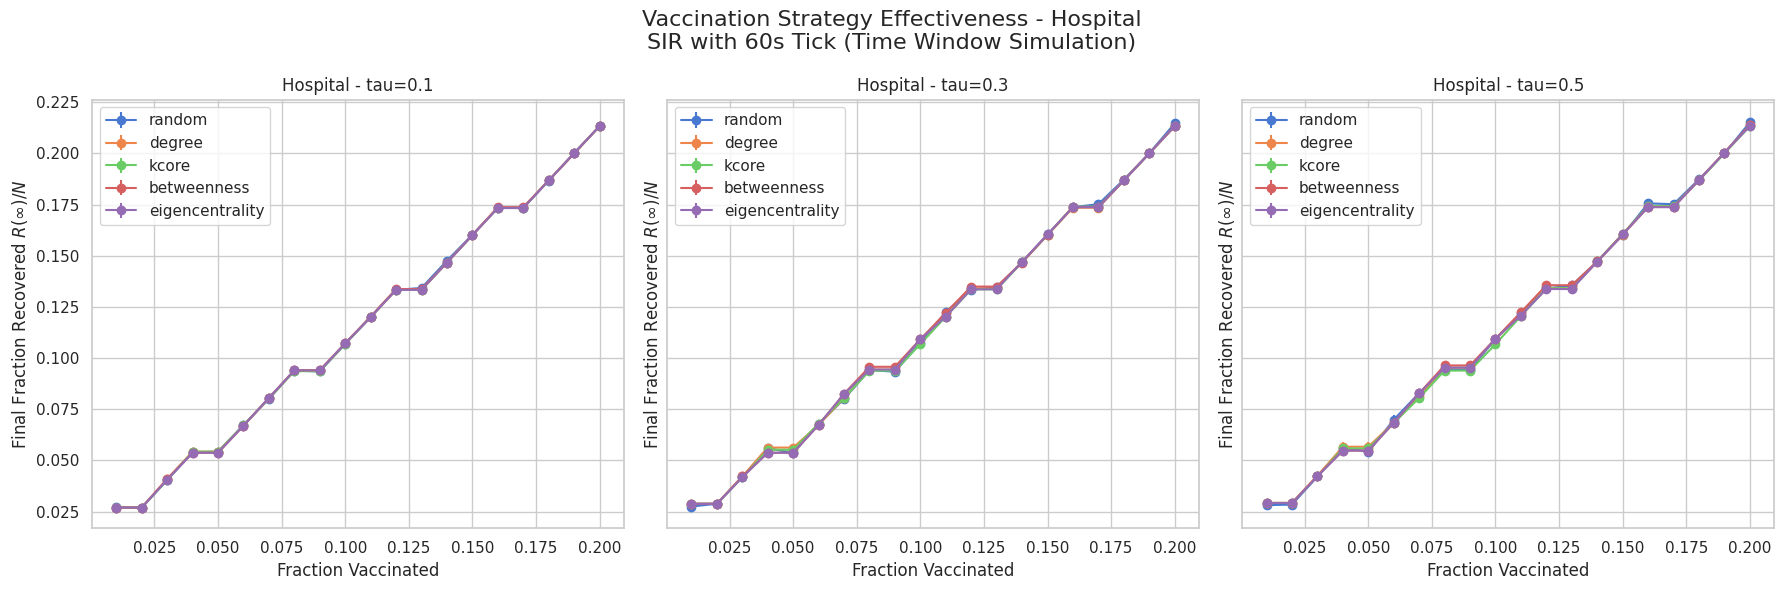

In [170]:
# Loop through each unique dataset in the results DataFrame
for ds_name in df_results_all['dataset'].unique():
    # Get all unique tau values for this dataset, sorted for better display order
    taus = sorted(df_results_all[df_results_all['dataset'] == ds_name]['tau'].unique())
    n_taus = len(taus)

    # Create subplots: one for each tau value
    fig, axes = plt.subplots(1, n_taus, figsize=(6*n_taus, 6), sharey=True)
    
    # If there's only one tau, axes is not a list; make it iterable for consistency
    if n_taus == 1:
        axes = [axes]

    # For each subplot (tau value) in this dataset
    for ax, tau in zip(axes, taus):
        # Plot each vaccination strategy as a separate line
        for strategy in strategies:
            # Filter results for the current dataset, tau, and strategy
            subset = df_results_all[
                (df_results_all['dataset'] == ds_name) &
                (df_results_all['tau'] == tau) &
                (df_results_all['strategy'] == strategy)
            ]
            # Plot mean recovered with error bars (95% confidence interval)
            ax.errorbar(
                subset['fraction'],                   # X-axis: fraction vaccinated
                subset['mean_R'],                     # Y-axis: mean final fraction recovered
                yerr=1.96 * subset['std_R'] / np.sqrt(subset['n']),  # Error bars
                label=strategy,                       # Label for legend
                marker='o'                            # Marker style
            )
        # Set titles and labels for each subplot
        ax.set_title(f'{ds_name} - tau={tau}')
        ax.set_xlabel('Fraction Vaccinated')
        ax.set_ylabel('Final Fraction Recovered $R(\\infty)/N$')
        ax.legend()

    # Set the main title for the figure
    fig.suptitle(
        f'Vaccination Strategy Effectiveness - {ds_name}\nSIR with {tick_size}s Tick (Time Window Simulation)',
        fontsize=16
    )
    # Adjust layout to fit everything
    plt.tight_layout(rect=[0, 0, 1, 1])
    plt.show()

## 10. Statistical Analysis

For each scenario, compare strategies using summary tables and statistical hypothesis tests (ANOVA, Kruskal-Wallis, t-test, Mann-Whitney). Present results in tables.

In [178]:
def analyze_by_dataset_tau(
    df_results_all,         # pd.DataFrame: Summary statistics for all simulation results
    df_raw_results,         # pd.DataFrame: Raw results of all individual simulations
    strategies,             # list: List of vaccination strategies (str) to compare
    show_plots=True,        # bool: Whether to display plots interactively
    save_plots=False,       # bool: Whether to save plots to disk
    plot_dir='plots'        # str: Directory where plots should be saved
):
    """
    For each unique (dataset, tau) combination, aggregate all simulation runs for all fractions
    and generate:
        - Boxplots comparing final outbreak size by strategy,
        - Summary statistics tables,
        - Statistical comparison tables (ANOVA, Kruskal-Wallis, t-test, Mann-Whitney).

    Args:
        df_results_all (pd.DataFrame): DataFrame with summary statistics (mean, std, median, etc) for all results.
        df_raw_results (pd.DataFrame): DataFrame with R_final for every individual run.
        strategies (list): List of strategies to be compared (e.g. ['random', 'degree', ...]).
        show_plots (bool): Whether to display plots in notebook/output.
        save_plots (bool): Whether to save plots as PNG files.
        plot_dir (str): Directory path to save plots if save_plots=True.

    Returns:
        None (outputs visualizations and tables, optionally saves figures to disk)
    """
    # Create directory to save plots if needed
    if save_plots and not os.path.exists(plot_dir):
        os.makedirs(plot_dir)

    # Get all unique scenario combinations (dataset, tau)
    scenarios = (
        df_results_all[['dataset', 'tau']]
        .drop_duplicates()
        .sort_values(['dataset', 'tau'])
    )

    # Iterate through each scenario (dataset, tau)
    for _, row in scenarios.iterrows():
        ds = row['dataset']
        tau = row['tau']

        # Boxplot for all fractions, grouped by strategy
        # Filter all runs matching dataset and tau (all fractions included)
        df_box = df_raw_results[
            (df_raw_results['dataset'] == ds) &
            (df_raw_results['tau'] == tau)
        ]
        plt.figure(figsize=(10, 7))
        sns.boxplot(data=df_box, x='strategy', y='R_final', order=strategies)
        plt.title(f'Boxplot of $R(\\infty)/N$ by Strategy\n{ds}, tau={tau}')
        plt.xlabel('Strategy')
        plt.ylabel('Final Fraction Recovered $R(\\infty)/N$')
        if save_plots:
            plt.savefig(f"{plot_dir}/boxplot_{ds}_tau{tau}.png", bbox_inches='tight')
        if show_plots:
            plt.show()
        plt.close()

        # Summary Statistics Table
        # Aggregate statistics for each strategy (across all fractions)
        summary = df_box.groupby('strategy')['R_final'].agg(
            mean_R='mean',
            std_R='std',
            median_R='median',
            q1_R=lambda x: np.percentile(x, 25),
            q3_R=lambda x: np.percentile(x, 75),
            iqr_R=lambda x: np.percentile(x, 75) - np.percentile(x, 25),
            n='count'
        ).reset_index()
        print(f"\nSummary statistics - {ds} tau={tau} (all fractions)")
        display(summary)  # Jupyter: pretty print table

        # Statistical Comparisons
        # Prepare R_final groups by strategy for statistical tests
        groups = []
        group_names = []
        for strategy in strategies:
            g = df_box[df_box['strategy'] == strategy]['R_final'].values
            if len(g) > 0:
                groups.append(g)
                group_names.append(strategy)

        results = {}
        if len(groups) > 1:
            # Global test: ANOVA (parametric)
            try:
                results['ANOVA p-value'] = f_oneway(*groups).pvalue
            except Exception:
                results['ANOVA p-value'] = np.nan
            # Global test: Kruskal-Wallis (non-parametric)
            try:
                results['Kruskal-Wallis p-value'] = kruskal(*groups).pvalue
            except Exception:
                results['Kruskal-Wallis p-value'] = np.nan
            print(f"Global tests for {ds} tau={tau}:")
            print(results)

            # Pairwise tests for every pair of strategies
            stat_tests = []
            for (s1, g1), (s2, g2) in combinations(zip(group_names, groups), 2):
                try:
                    t_p = ttest_ind(g1, g2, equal_var=False).pvalue
                except Exception:
                    t_p = np.nan
                try:
                    mw_p = mannwhitneyu(g1, g2, alternative='two-sided').pvalue
                except Exception:
                    mw_p = np.nan
                stat_tests.append({
                    'Strategy 1': s1,
                    'Strategy 2': s2,
                    't-test p-value': t_p,
                    'Mann-Whitney p-value': mw_p
                })
            df_stats = pd.DataFrame(stat_tests)
            print("Pairwise comparisons:")
            display(df_stats)  # Jupyter: pretty print table
        else:
            print("Not enough data for statistical tests.")


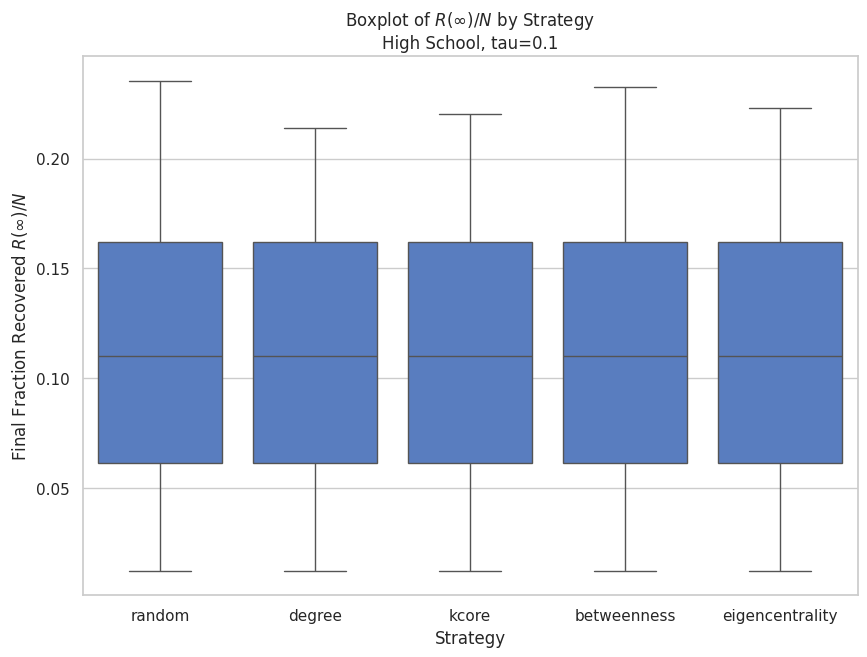


Summary statistics - High School tau=0.1 (all fractions)


,strategy,mean_R,std_R,median_R,q1_R,q3_R,iqr_R,n
0,betweenness,0.108326,0.057873,0.110092,0.061162,0.16208,0.100917,2000
1,degree,0.108239,0.057756,0.110092,0.061162,0.16208,0.100917,2000
2,eigencentrality,0.108329,0.057693,0.110092,0.061162,0.16208,0.100917,2000
3,kcore,0.108417,0.057546,0.110092,0.061162,0.16208,0.100917,2000
4,random,0.108633,0.057872,0.110092,0.061162,0.16208,0.100917,2000


Global tests for High School tau=0.1:
{'ANOVA p-value': 0.9996372155577299, 'Kruskal-Wallis p-value': 0.9998605102790072}
Pairwise comparisons:


,Strategy 1,Strategy 2,t-test p-value,Mann-Whitney p-value
0,random,degree,0.829171,0.865356
1,random,kcore,0.905963,0.912944
2,random,betweenness,0.866642,0.890146
3,random,eigencentrality,0.867753,0.898696
4,degree,kcore,0.921834,0.952435
5,degree,betweenness,0.961980,0.974394
6,degree,eigencentrality,0.960586,0.964477
7,kcore,betweenness,0.959908,0.975235
8,kcore,eigencentrality,0.961183,0.985976
9,betweenness,eigencentrality,0.998665,0.991081


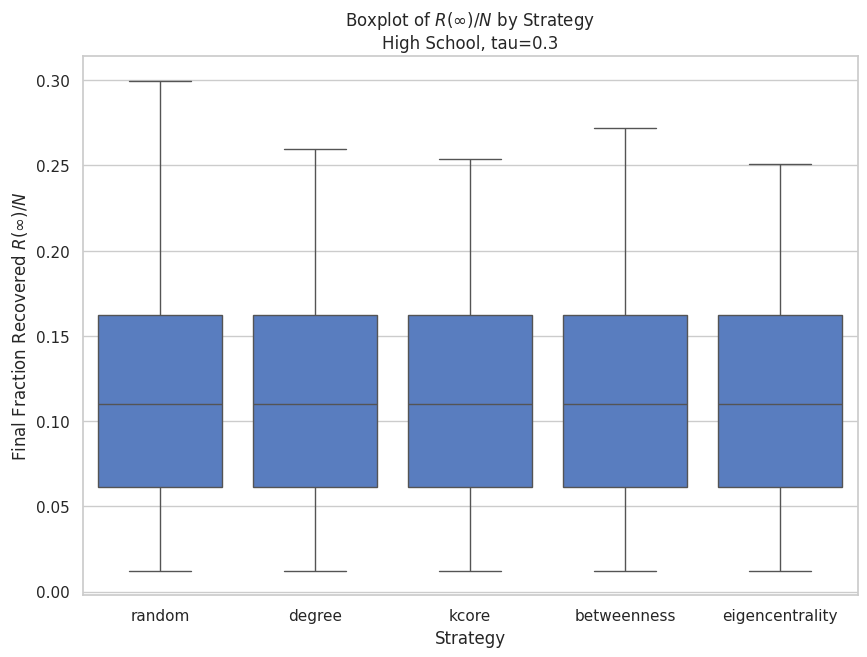


Summary statistics - High School tau=0.3 (all fractions)


,strategy,mean_R,std_R,median_R,q1_R,q3_R,iqr_R,n
0,betweenness,0.112101,0.058486,0.110092,0.061162,0.16208,0.100917,2000
1,degree,0.111980,0.058528,0.110092,0.061162,0.16208,0.100917,2000
2,eigencentrality,0.112641,0.058067,0.110092,0.061162,0.16208,0.100917,2000
3,kcore,0.112222,0.058180,0.110092,0.061162,0.16208,0.100917,2000
4,random,0.113815,0.058965,0.110092,0.061162,0.16208,0.100917,2000


Global tests for High School tau=0.3:
{'ANOVA p-value': 0.8591549879768338, 'Kruskal-Wallis p-value': 0.9181051734396521}
Pairwise comparisons:


,Strategy 1,Strategy 2,t-test p-value,Mann-Whitney p-value
0,random,degree,0.323365,0.399303
1,random,kcore,0.389744,0.470264
2,random,betweenness,0.356067,0.445190
3,random,eigencentrality,0.525727,0.640096
4,degree,kcore,0.895845,0.902915
5,degree,betweenness,0.947947,0.926324
6,degree,eigencentrality,0.720134,0.699238
7,kcore,betweenness,0.947793,0.970552
8,kcore,eigencentrality,0.819705,0.796323
9,betweenness,eigencentrality,0.769624,0.768402


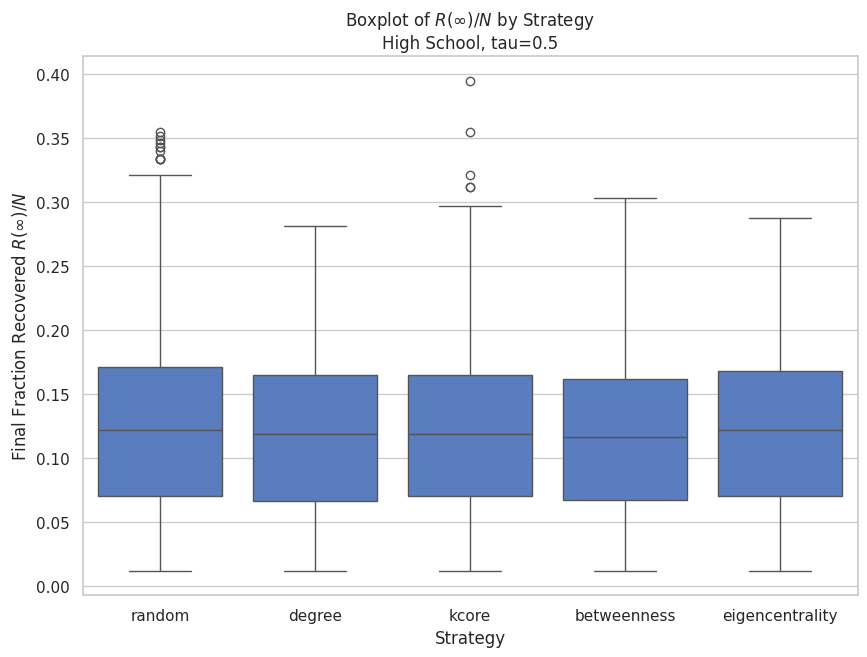


Summary statistics - High School tau=0.5 (all fractions)


,strategy,mean_R,std_R,median_R,q1_R,q3_R,iqr_R,n
0,betweenness,0.116234,0.059834,0.116208,0.067278,0.162080,0.094801,2000
1,degree,0.116196,0.059866,0.119266,0.066514,0.165138,0.098624,2000
2,eigencentrality,0.117642,0.059254,0.122324,0.070336,0.168196,0.097859,2000
3,kcore,0.117566,0.061185,0.119266,0.070336,0.165138,0.094801,2000
4,random,0.122706,0.067160,0.122324,0.070336,0.171254,0.100917,2000


Global tests for High School tau=0.5:
{'ANOVA p-value': 0.004277433460876184, 'Kruskal-Wallis p-value': 0.12161164130613299}
Pairwise comparisons:


,Strategy 1,Strategy 2,t-test p-value,Mann-Whitney p-value
0,random,degree,0.001221,0.022351
1,random,kcore,0.011429,0.058450
2,random,betweenness,0.001301,0.021357
3,random,eigencentrality,0.011487,0.127038
4,degree,kcore,0.474183,0.704722
5,degree,betweenness,0.983887,0.981347
6,degree,eigencentrality,0.442544,0.426621
7,kcore,betweenness,0.486487,0.683020
8,kcore,eigencentrality,0.967982,0.681955
9,betweenness,eigencentrality,0.454570,0.412080


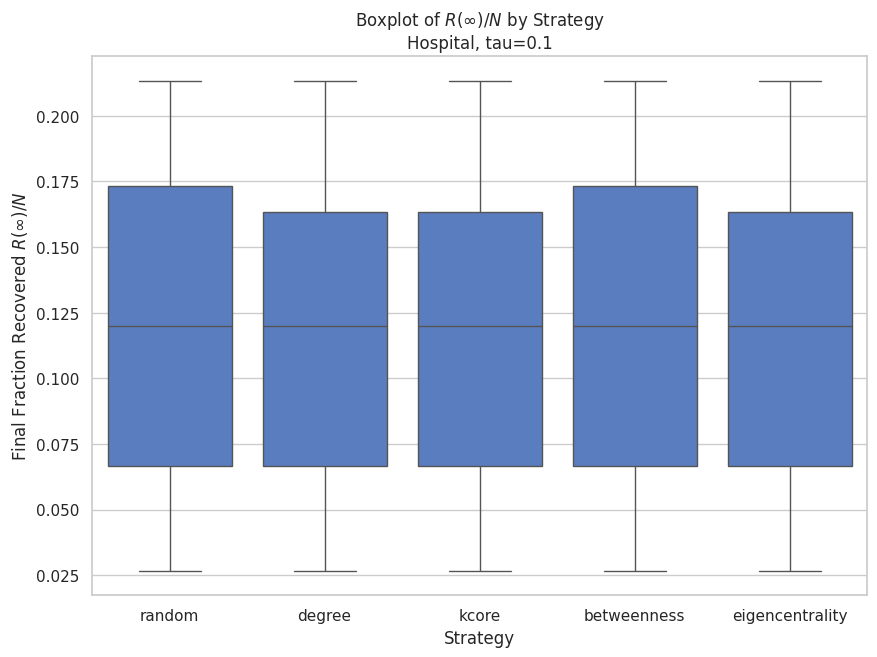


Summary statistics - Hospital tau=0.1 (all fractions)


,strategy,mean_R,std_R,median_R,q1_R,q3_R,iqr_R,n
0,betweenness,0.114353,0.057385,0.12,0.066667,0.173333,0.106667,2000
1,degree,0.114313,0.057283,0.12,0.066667,0.163333,0.096667,2000
2,eigencentrality,0.114233,0.057328,0.12,0.066667,0.163333,0.096667,2000
3,kcore,0.114260,0.057312,0.12,0.066667,0.163333,0.096667,2000
4,random,0.114340,0.057373,0.12,0.066667,0.173333,0.106667,2000


Global tests for Hospital tau=0.1:
{'ANOVA p-value': 0.9999947464483833, 'Kruskal-Wallis p-value': 0.9999939873609475}
Pairwise comparisons:


,Strategy 1,Strategy 2,t-test p-value,Mann-Whitney p-value
0,random,degree,0.988265,0.988155
1,random,kcore,0.964813,0.965155
2,random,betweenness,0.994137,0.991212
3,random,eigencentrality,0.953102,0.953072
4,degree,kcore,0.976519,0.977310
5,degree,betweenness,0.982400,0.979018
6,degree,eigencentrality,0.964790,0.965000
7,kcore,betweenness,0.958957,0.955906
8,kcore,eigencentrality,0.988263,0.988199
9,betweenness,eigencentrality,0.947254,0.944017


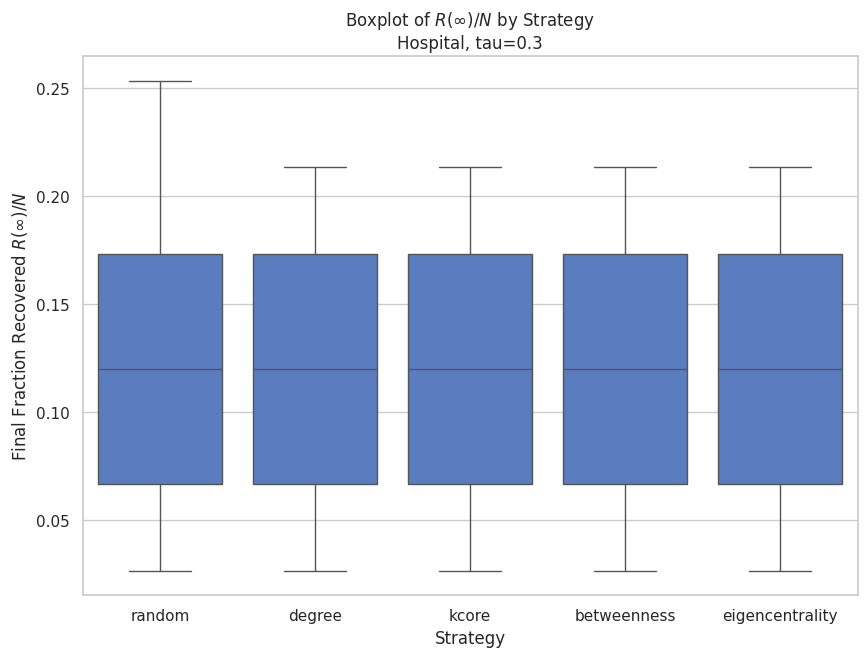


Summary statistics - Hospital tau=0.3 (all fractions)


,strategy,mean_R,std_R,median_R,q1_R,q3_R,iqr_R,n
0,betweenness,0.115227,0.057245,0.12,0.066667,0.173333,0.106667,2000
1,degree,0.115027,0.056941,0.12,0.066667,0.173333,0.106667,2000
2,eigencentrality,0.114860,0.057133,0.12,0.066667,0.173333,0.106667,2000
3,kcore,0.114767,0.057023,0.12,0.066667,0.173333,0.106667,2000
4,random,0.114953,0.057512,0.12,0.066667,0.173333,0.106667,2000


Global tests for Hospital tau=0.3:
{'ANOVA p-value': 0.9993120365197588, 'Kruskal-Wallis p-value': 0.9992393998560215}
Pairwise comparisons:


,Strategy 1,Strategy 2,t-test p-value,Mann-Whitney p-value
0,random,degree,0.967679,0.936687
1,random,kcore,0.917909,0.953030
2,random,betweenness,0.880267,0.846317
3,random,eigencentrality,0.958939,0.995650
4,degree,kcore,0.885280,0.888381
5,degree,betweenness,0.911800,0.907822
6,degree,eigencentrality,0.926382,0.931795
7,kcore,betweenness,0.799044,0.797473
8,kcore,eigencentrality,0.958763,0.955503
9,betweenness,eigencentrality,0.839342,0.839988


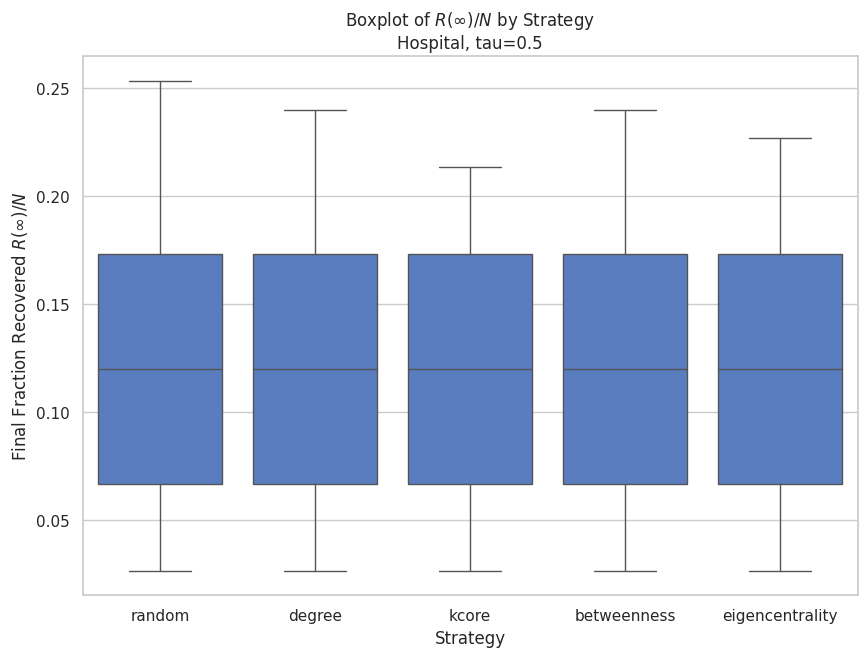


Summary statistics - Hospital tau=0.5 (all fractions)


,strategy,mean_R,std_R,median_R,q1_R,q3_R,iqr_R,n
0,betweenness,0.115713,0.057281,0.12,0.066667,0.173333,0.106667,2000
1,degree,0.115467,0.056967,0.12,0.066667,0.173333,0.106667,2000
2,eigencentrality,0.115267,0.057032,0.12,0.066667,0.173333,0.106667,2000
3,kcore,0.115060,0.057032,0.12,0.066667,0.173333,0.106667,2000
4,random,0.115600,0.057582,0.12,0.066667,0.173333,0.106667,2000


Global tests for Hospital tau=0.5:
{'ANOVA p-value': 0.9966843769578713, 'Kruskal-Wallis p-value': 0.9975602934302645}
Pairwise comparisons:


,Strategy 1,Strategy 2,t-test p-value,Mann-Whitney p-value
0,random,degree,0.941320,0.980587
1,random,kcore,0.765737,0.814439
2,random,betweenness,0.950245,0.901138
3,random,eigencentrality,0.854073,0.909613
4,degree,kcore,0.821513,0.832737
5,degree,betweenness,0.891394,0.883062
6,degree,eigencentrality,0.911655,0.926354
7,kcore,betweenness,0.717771,0.721679
8,kcore,eigencentrality,0.908775,0.904170
9,betweenness,eigencentrality,0.804824,0.810622


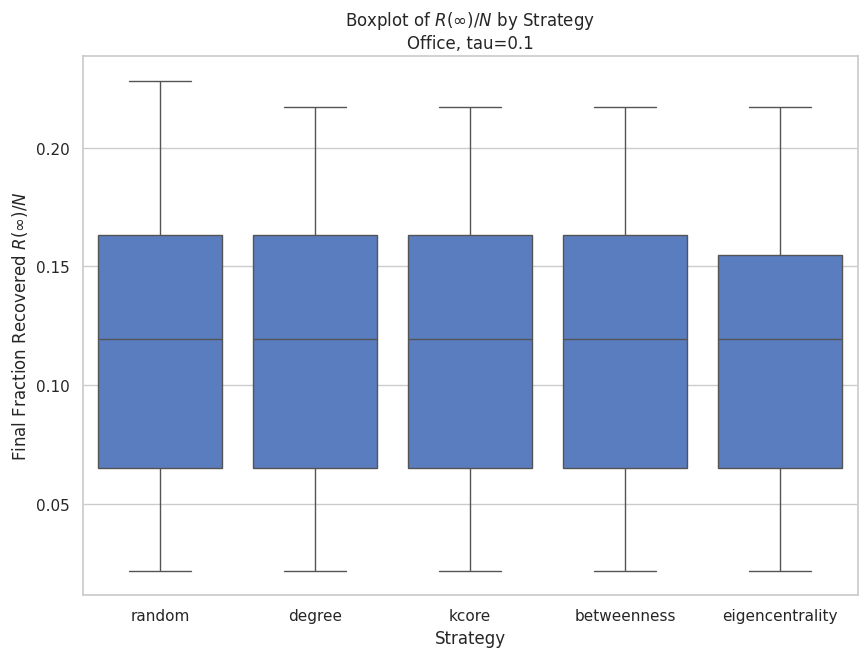


Summary statistics - Office tau=0.1 (all fractions)


,strategy,mean_R,std_R,median_R,q1_R,q3_R,iqr_R,n
0,betweenness,0.110462,0.057279,0.119565,0.065217,0.163043,0.097826,2000
1,degree,0.110440,0.057301,0.119565,0.065217,0.163043,0.097826,2000
2,eigencentrality,0.110435,0.057295,0.119565,0.065217,0.154891,0.089674,2000
3,kcore,0.110565,0.057374,0.119565,0.065217,0.163043,0.097826,2000
4,random,0.110516,0.057356,0.119565,0.065217,0.163043,0.097826,2000


Global tests for Office tau=0.1:
{'ANOVA p-value': 0.999992821109061, 'Kruskal-Wallis p-value': 0.9999936858044314}
Pairwise comparisons:


,Strategy 1,Strategy 2,t-test p-value,Mann-Whitney p-value
0,random,degree,0.966525,0.967194
1,random,kcore,0.978490,0.979052
2,random,betweenness,0.976081,0.975945
3,random,eigencentrality,0.964133,0.966133
4,degree,kcore,0.945041,0.946352
5,degree,betweenness,0.990427,0.991200
6,degree,eigencentrality,0.997607,0.998916
7,kcore,betweenness,0.954579,0.955179
8,kcore,eigencentrality,0.942652,0.945227
9,betweenness,eigencentrality,0.988033,0.990105


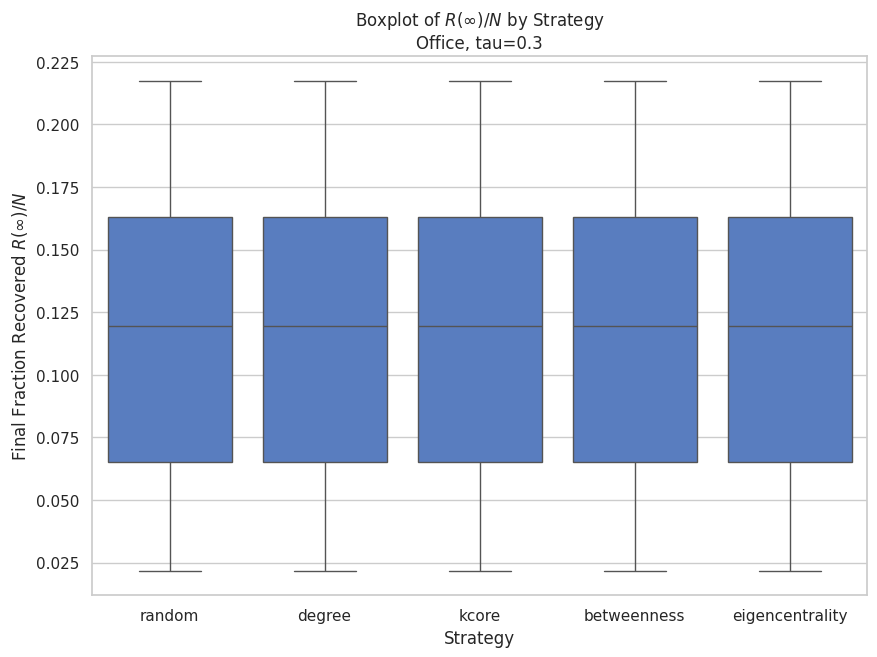


Summary statistics - Office tau=0.3 (all fractions)


,strategy,mean_R,std_R,median_R,q1_R,q3_R,iqr_R,n
0,betweenness,0.110658,0.057272,0.119565,0.065217,0.163043,0.097826,2000
1,degree,0.110620,0.057298,0.119565,0.065217,0.163043,0.097826,2000
2,eigencentrality,0.110560,0.057271,0.119565,0.065217,0.163043,0.097826,2000
3,kcore,0.110614,0.057322,0.119565,0.065217,0.163043,0.097826,2000
4,random,0.110717,0.057350,0.119565,0.065217,0.163043,0.097826,2000


Global tests for Office tau=0.3:
{'ANOVA p-value': 0.9999914165369194, 'Kruskal-Wallis p-value': 0.9999884830341768}
Pairwise comparisons:


,Strategy 1,Strategy 2,t-test p-value,Mann-Whitney p-value
0,random,degree,0.956965,0.953956
1,random,kcore,0.954586,0.950012
2,random,betweenness,0.973687,0.968496
3,random,eigencentrality,0.930704,0.924796
4,degree,kcore,0.997607,0.995731
5,degree,betweenness,0.983246,0.985662
6,degree,eigencentrality,0.973675,0.970443
7,kcore,betweenness,0.980857,0.981263
8,kcore,eigencentrality,0.976072,0.974862
9,betweenness,eigencentrality,0.956926,0.956196


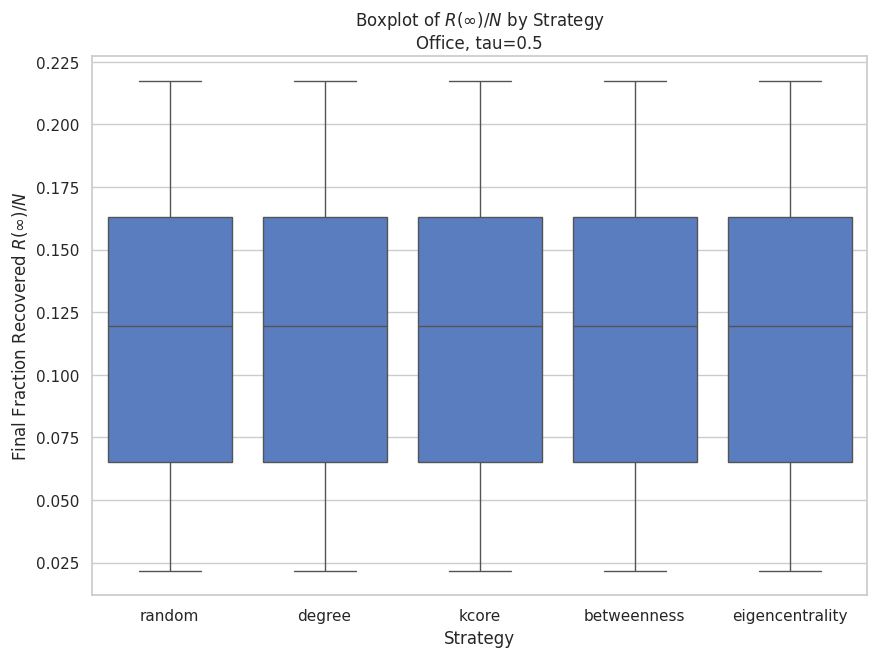


Summary statistics - Office tau=0.5 (all fractions)


,strategy,mean_R,std_R,median_R,q1_R,q3_R,iqr_R,n
0,betweenness,0.110707,0.057268,0.119565,0.065217,0.163043,0.097826,2000
1,degree,0.110668,0.057293,0.119565,0.065217,0.163043,0.097826,2000
2,eigencentrality,0.110592,0.057234,0.119565,0.065217,0.163043,0.097826,2000
3,kcore,0.110679,0.057293,0.119565,0.065217,0.163043,0.097826,2000
4,random,0.110728,0.057357,0.119565,0.065217,0.163043,0.097826,2000


Global tests for Office tau=0.5:
{'ANOVA p-value': 0.999994680312946, 'Kruskal-Wallis p-value': 0.9999945871628704}
Pairwise comparisons:


,Strategy 1,Strategy 2,t-test p-value,Mann-Whitney p-value
0,random,degree,0.973693,0.974458
1,random,kcore,0.978475,0.981143
2,random,betweenness,0.990430,0.989077
3,random,eigencentrality,0.940227,0.939705
4,degree,kcore,0.995213,0.993247
5,degree,betweenness,0.983245,0.985673
6,degree,eigencentrality,0.966487,0.964953
7,kcore,betweenness,0.988031,0.992130
8,kcore,eigencentrality,0.961703,0.958405
9,betweenness,eigencentrality,0.949738,0.950701


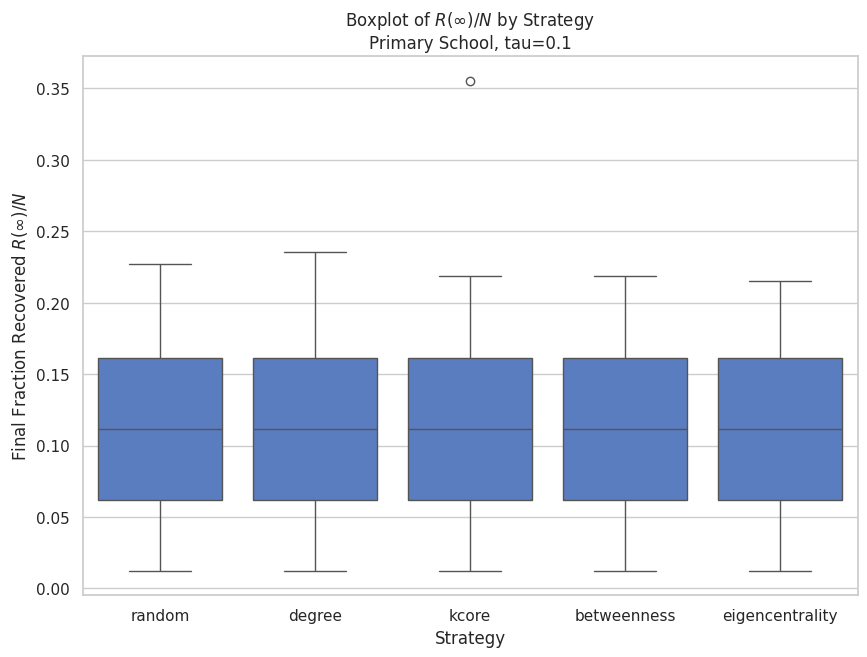


Summary statistics - Primary School tau=0.1 (all fractions)


,strategy,mean_R,std_R,median_R,q1_R,q3_R,iqr_R,n
0,betweenness,0.108593,0.057620,0.11157,0.061983,0.161157,0.099174,2000
1,degree,0.108574,0.057798,0.11157,0.061983,0.161157,0.099174,2000
2,eigencentrality,0.108444,0.057603,0.11157,0.061983,0.161157,0.099174,2000
3,kcore,0.108808,0.058049,0.11157,0.061983,0.161157,0.099174,2000
4,random,0.108504,0.057706,0.11157,0.061983,0.161157,0.099174,2000


Global tests for Primary School tau=0.1:
{'ANOVA p-value': 0.9997429788322922, 'Kruskal-Wallis p-value': 0.9999093156865454}
Pairwise comparisons:


,Strategy 1,Strategy 2,t-test p-value,Mann-Whitney p-value
0,random,degree,0.969319,0.975942
1,random,kcore,0.868210,0.908717
2,random,betweenness,0.961143,0.953324
3,random,eigencentrality,0.973785,0.968806
4,degree,kcore,0.898582,0.933586
5,degree,betweenness,0.991871,0.976587
6,degree,eigencentrality,0.943133,0.944976
7,kcore,betweenness,0.906479,0.956620
8,kcore,eigencentrality,0.842385,0.878410
9,betweenness,eigencentrality,0.934926,0.921664


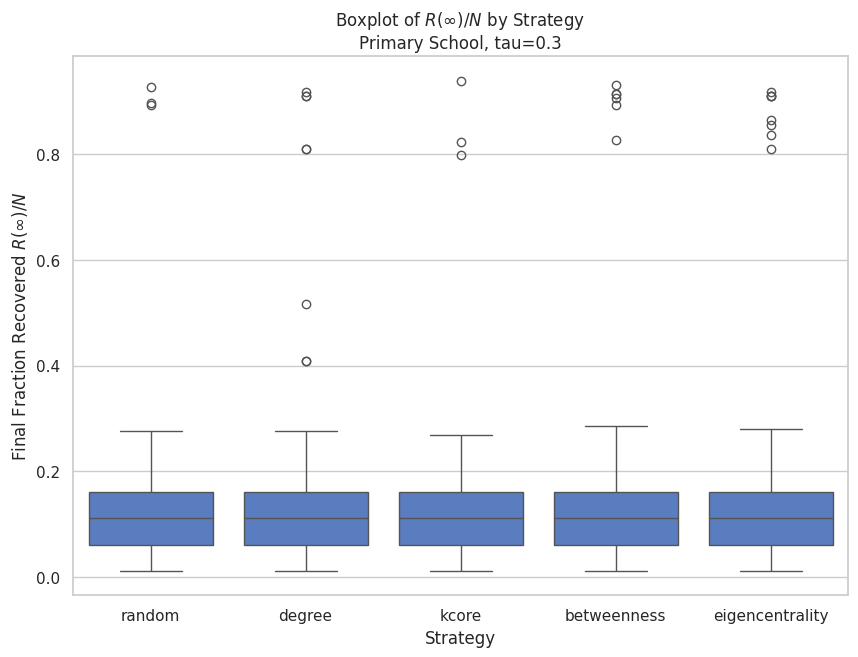


Summary statistics - Primary School tau=0.3 (all fractions)


,strategy,mean_R,std_R,median_R,q1_R,q3_R,iqr_R,n
0,betweenness,0.115192,0.072821,0.11157,0.061983,0.161157,0.099174,2000
1,degree,0.115640,0.071591,0.11157,0.061983,0.161157,0.099174,2000
2,eigencentrality,0.115911,0.075949,0.11157,0.061983,0.161157,0.099174,2000
3,kcore,0.114002,0.065761,0.11157,0.061983,0.161157,0.099174,2000
4,random,0.114151,0.065676,0.11157,0.061983,0.161157,0.099174,2000


Global tests for Primary School tau=0.3:
{'ANOVA p-value': 0.8772890135730075, 'Kruskal-Wallis p-value': 0.9990967736051011}
Pairwise comparisons:


,Strategy 1,Strategy 2,t-test p-value,Mann-Whitney p-value
0,random,degree,0.492928,0.843696
1,random,kcore,0.942939,0.933378
2,random,betweenness,0.634889,0.988830
3,random,eigencentrality,0.433057,0.949481
4,degree,kcore,0.451040,0.778618
5,degree,betweenness,0.844348,0.851126
6,degree,eigencentrality,0.907680,0.892395
7,kcore,betweenness,0.587558,0.920482
8,kcore,eigencentrality,0.395465,0.886088
9,betweenness,eigencentrality,0.759925,0.960701


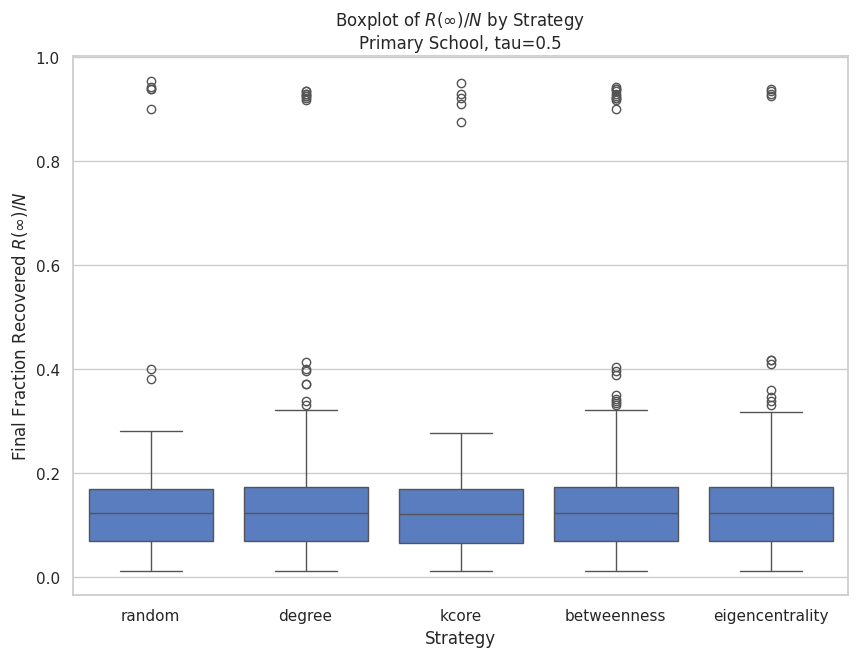


Summary statistics - Primary School tau=0.5 (all fractions)


,strategy,mean_R,std_R,median_R,q1_R,q3_R,iqr_R,n
0,betweenness,0.123864,0.084987,0.123967,0.070248,0.173554,0.103306,2000
1,degree,0.123826,0.081129,0.123967,0.070248,0.173554,0.103306,2000
2,eigencentrality,0.122612,0.073347,0.123967,0.070248,0.173554,0.103306,2000
3,kcore,0.119070,0.072579,0.121901,0.066116,0.169421,0.103306,2000
4,random,0.120752,0.073746,0.123967,0.070248,0.169421,0.099174,2000


Global tests for Primary School tau=0.5:
{'ANOVA p-value': 0.21510116859934242, 'Kruskal-Wallis p-value': 0.5950192726620268}
Pairwise comparisons:


,Strategy 1,Strategy 2,t-test p-value,Mann-Whitney p-value
0,random,degree,0.209901,0.461593
1,random,kcore,0.467329,0.485271
2,random,betweenness,0.216281,0.722880
3,random,eigencentrality,0.424031,0.486118
4,degree,kcore,0.050774,0.154346
5,degree,betweenness,0.988707,0.705925
6,degree,eigencentrality,0.619382,0.966808
7,kcore,betweenness,0.055173,0.291779
8,kcore,eigencentrality,0.124908,0.166281
9,betweenness,eigencentrality,0.617958,0.737119


In [179]:
analyze_by_dataset_tau(
    df_results_all,
    df_raw_results,
    strategies,
    show_plots=True,
    save_plots=False,
    plot_dir='plots'
)

## 11. Discussion

Interpret and discuss the results in the context of network structure and epidemiological dynamics.